# 🧬 Développement et Tests - NSGA-II

Ce notebook développe et teste l'optimisation par algorithme génétique NSGA-II avec contraintes opérationnelles.

**Objectifs:**
- Implémenter l'optimisation tri-objectif (rendement, risque, coûts)
- Tester la contrainte de cardinalité
- Analyser le front de Pareto 3D
- Comparer avec les résultats de Markowitz
- Étudier la diversité des solutions

In [1]:
# Imports
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pathlib import Path
import time

from data_loader import prepare_data
from financial_metrics import (
    portfolio_return, portfolio_risk, portfolio_volatility,
    sharpe_ratio, portfolio_cardinality, transaction_costs
)
from optimizers.genetic import (
    optimize_nsga2,
    optimize_nsga2_biobjective,
    extract_pareto_front,
    select_portfolio_from_front
)
from optimizers.classic import find_tangency_portfolio

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Imports réussis")

✅ Imports réussis


## 1. Chargement des Données

In [2]:
# Charge les données
prices, returns, mu, Sigma, ticker_sectors = prepare_data(
    start_date="2020-01-01",
    end_date="2024-12-31",
    data_dir="../data/raw"
)

tickers = list(prices.columns)
n_assets = len(tickers)
rf = 0.02

print(f"📊 Nombre d'actifs: {n_assets}")

# Paramètres d'optimisation
K = 20  # Cardinalité cible
c_prop = 0.005  # Coût de transaction 0.5%
w_current = np.zeros(n_assets)  # Pas de portefeuille initial

print(f"\n🎯 Contraintes:")
print(f"  - Cardinalité: {K} actifs")
print(f"  - Coût de transaction: {c_prop*100}%")

📊 Nombre d'actifs: 196

🎯 Contraintes:
  - Cardinalité: 20 actifs
  - Coût de transaction: 0.5%


c:\Users\redlam\Downloads\PROJET_PORTFOLIO_OPTIMIZATION\notebooks\../src\data_loader.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')


## 2. NSGA-II Bi-Objectif (Comparaison avec Markowitz)

In [3]:
# Optimisation bi-objectif SANS contrainte de cardinalité
print("🔍 NSGA-II bi-objectif sans contrainte de cardinalité...")
start_time = time.time()

res_nsga_bi = optimize_nsga2_biobjective(
    mu=mu,
    Sigma=Sigma,
    K=K,  # Pas de contrainte
    pop_size=100,
    n_gen=100,
    seed=42
)

elapsed = time.time() - start_time
X_nsga_bi, F_nsga_bi = extract_pareto_front(res_nsga_bi)

rets_nsga_bi = -F_nsga_bi[:, 0]
risks_nsga_bi = F_nsga_bi[:, 1]
vols_nsga_bi = np.sqrt(risks_nsga_bi)

print(f"✅ Terminé en {elapsed:.2f}s")
print(f"📊 Nombre de solutions Pareto: {len(X_nsga_bi)}")
print(f"📈 Rendement: [{rets_nsga_bi.min()*100:.2f}%, {rets_nsga_bi.max()*100:.2f}%]")
print(f"📊 Volatilité: [{vols_nsga_bi.min()*100:.2f}%, {vols_nsga_bi.max()*100:.2f}%]")

🔍 NSGA-II bi-objectif sans contrainte de cardinalité...
✅ Terminé en 2.41s
📊 Nombre de solutions Pareto: 11
📈 Rendement: [8.15%, 17.80%]
📊 Volatilité: [18.84%, 23.66%]


In [4]:
# Optimisation bi-objectif AVEC contrainte de cardinalité K=20
print(f"\n🔍 NSGA-II bi-objectif avec contrainte K={K}...")
start_time = time.time()

res_nsga_bi_K = optimize_nsga2_biobjective(
    mu=mu,
    Sigma=Sigma,
    K=K,
    pop_size=500,
    n_gen=200,
    seed=42
)

elapsed = time.time() - start_time
X_nsga_bi_K, F_nsga_bi_K = extract_pareto_front(res_nsga_bi_K)

rets_nsga_bi_K = -F_nsga_bi_K[:, 0]
risks_nsga_bi_K = F_nsga_bi_K[:, 1]
vols_nsga_bi_K = np.sqrt(risks_nsga_bi_K)

print(f"✅ Terminé en {elapsed:.2f}s")
print(f"📊 Nombre de solutions Pareto: {len(X_nsga_bi_K)}")
print(f"📈 Rendement: [{rets_nsga_bi_K.min()*100:.2f}%, {rets_nsga_bi_K.max()*100:.2f}%]")
print(f"📊 Volatilité: [{vols_nsga_bi_K.min()*100:.2f}%, {vols_nsga_bi_K.max()*100:.2f}%]")

# Vérification de la cardinalité
cards_K = [portfolio_cardinality(w) for w in X_nsga_bi_K]
print(f"\n🎯 Cardinalité des solutions:")
print(f"  Min: {min(cards_K)}, Max: {max(cards_K)}, Moyenne: {np.mean(cards_K):.1f}")


🔍 NSGA-II bi-objectif avec contrainte K=20...
✅ Terminé en 27.52s
📊 Nombre de solutions Pareto: 94
📈 Rendement: [10.78%, 33.68%]
📊 Volatilité: [18.18%, 33.83%]

🎯 Cardinalité des solutions:
  Min: 20, Max: 20, Moyenne: 20.0


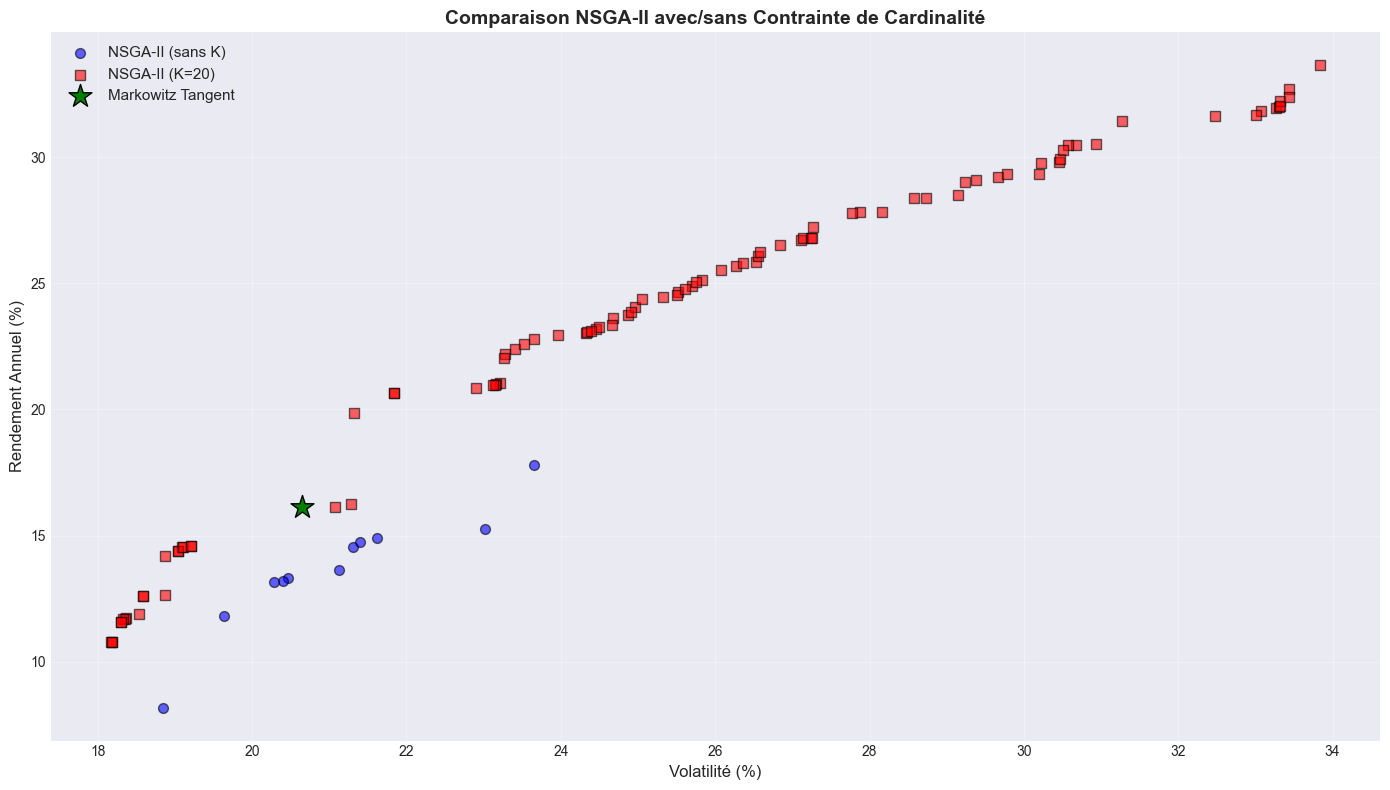

In [5]:
# Comparaison visuelle
fig, ax = plt.subplots(figsize=(14, 8))

# NSGA-II sans contrainte
ax.scatter(vols_nsga_bi * 100, rets_nsga_bi * 100,
          c='blue', s=50, alpha=0.6, label='NSGA-II (sans K)', marker='o', edgecolors='black')

# NSGA-II avec K=20
ax.scatter(vols_nsga_bi_K * 100, rets_nsga_bi_K * 100,
          c='red', s=50, alpha=0.6, label=f'NSGA-II (K={K})', marker='s', edgecolors='black')

# Portefeuille tangent Markowitz
w_tangent = find_tangency_portfolio(mu, Sigma, rf)
ret_tangent = portfolio_return(w_tangent, mu)
vol_tangent = portfolio_volatility(w_tangent, Sigma)
ax.scatter(vol_tangent * 100, ret_tangent * 100,
          c='green', s=300, marker='*', edgecolors='black',
          label='Markowitz Tangent', zorder=5)

ax.set_xlabel('Volatilité (%)', fontsize=12)
ax.set_ylabel('Rendement Annuel (%)', fontsize=12)
ax.set_title('Comparaison NSGA-II avec/sans Contrainte de Cardinalité', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. NSGA-II Tri-Objectif avec Coûts de Transaction

In [6]:
# Optimisation tri-objectif: rendement, risque, coûts
print("🔍 NSGA-II tri-objectif (rendement, risque, coûts)...")
print(f"   Cardinalité: K={K}")
print(f"   Coût proportionnel: {c_prop*100}%")
print(f"   Population: 150, Générations: 150\n")

start_time = time.time()

res_nsga_tri = optimize_nsga2(
    mu=mu,
    Sigma=Sigma,
    w_current=w_current,
    K=K,
    c_prop=c_prop,
    pop_size=150,
    n_gen=150,
    seed=42
)

elapsed = time.time() - start_time
X_tri, F_tri = extract_pareto_front(res_nsga_tri)

rets_tri = -F_tri[:, 0]
risks_tri = F_tri[:, 1]
costs_tri = F_tri[:, 2]
vols_tri = np.sqrt(risks_tri)

print(f"✅ Terminé en {elapsed:.2f}s ({elapsed/60:.1f} minutes)")
print(f"\n📊 Front de Pareto 3D: {len(X_tri)} solutions")
print(f"📈 Rendement: [{rets_tri.min()*100:.2f}%, {rets_tri.max()*100:.2f}%]")
print(f"📊 Volatilité: [{vols_tri.min()*100:.2f}%, {vols_tri.max()*100:.2f}%]")
print(f"💰 Coûts: [{costs_tri.min()*100:.3f}%, {costs_tri.max()*100:.3f}%]")

🔍 NSGA-II tri-objectif (rendement, risque, coûts)...
   Cardinalité: K=20
   Coût proportionnel: 0.5%
   Population: 150, Générations: 150

✅ Terminé en 5.74s (0.1 minutes)

📊 Front de Pareto 3D: 150 solutions
📈 Rendement: [10.83%, 26.95%]
📊 Volatilité: [16.54%, 29.33%]
💰 Coûts: [0.500%, 0.500%]


In [7]:
# Vérification de la cardinalité
cards_tri = [portfolio_cardinality(w) for w in X_tri]
print(f"🎯 Cardinalité des solutions tri-objectif:")
print(f"  Min: {min(cards_tri)}, Max: {max(cards_tri)}, Moyenne: {np.mean(cards_tri):.1f}")
print(f"  Cible K: {K}")
print(f"  Nb solutions avec K={K}: {sum(c == K for c in cards_tri)}/{len(cards_tri)}")

🎯 Cardinalité des solutions tri-objectif:
  Min: 20, Max: 20, Moyenne: 20.0
  Cible K: 20
  Nb solutions avec K=20: 150/150


## 4. Visualisation du Front de Pareto 3D

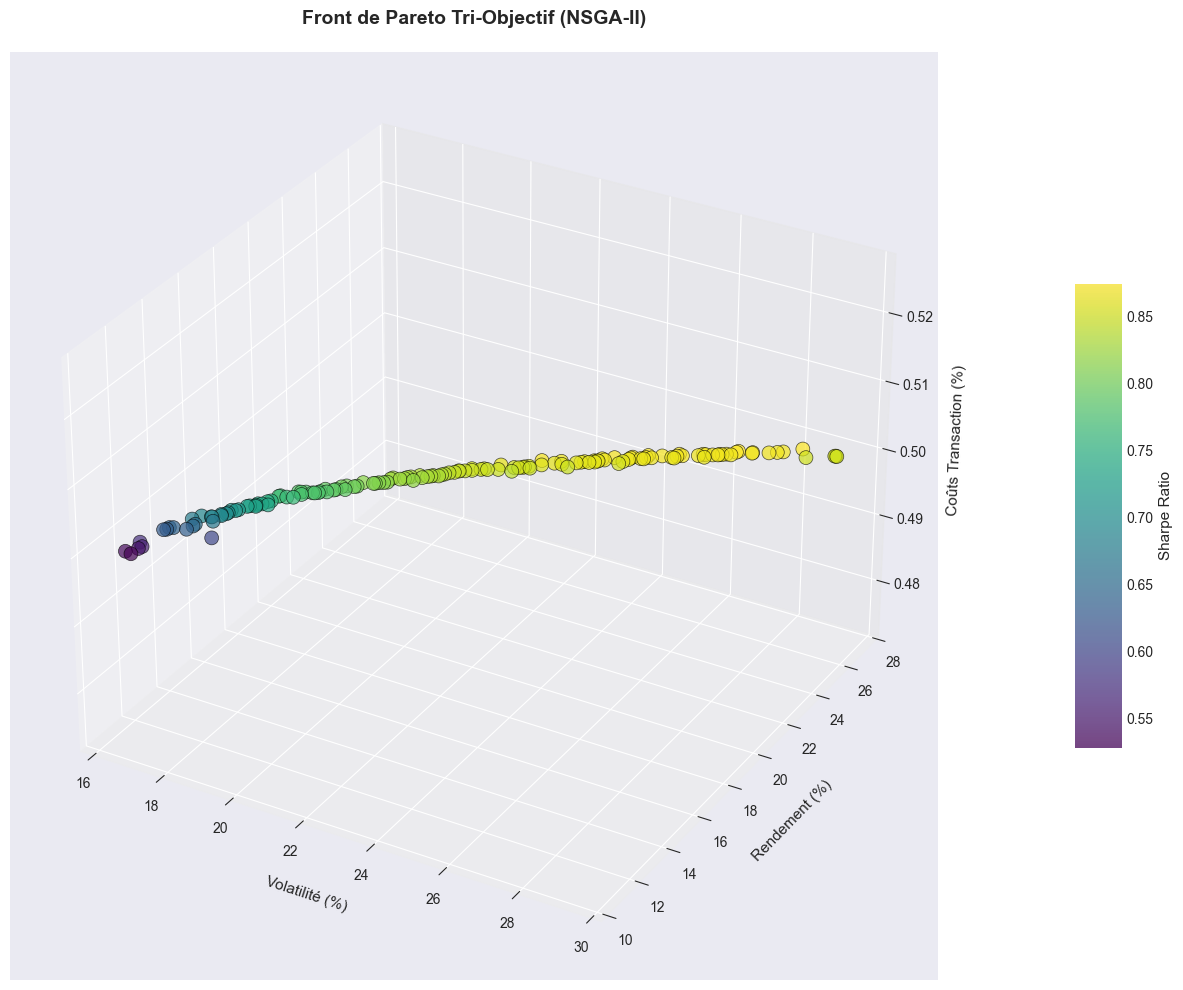

In [8]:
# Visualisation 3D interactive
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Coloration par Sharpe ratio
sharpe_tri = (rets_tri - rf) / vols_tri
scatter = ax.scatter(vols_tri * 100, rets_tri * 100, costs_tri * 100,
                    c=sharpe_tri, cmap='viridis', s=100, alpha=0.7, 
                    edgecolors='black', linewidth=0.5)

ax.set_xlabel('Volatilité (%)', fontsize=11, labelpad=10)
ax.set_ylabel('Rendement (%)', fontsize=11, labelpad=10)
ax.set_zlabel('Coûts Transaction (%)', fontsize=11, labelpad=10)
ax.set_title('Front de Pareto Tri-Objectif (NSGA-II)', fontsize=14, fontweight='bold', pad=20)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Sharpe Ratio', fontsize=11)

plt.tight_layout()
plt.show()

## 5. Projections 2D du Front 3D

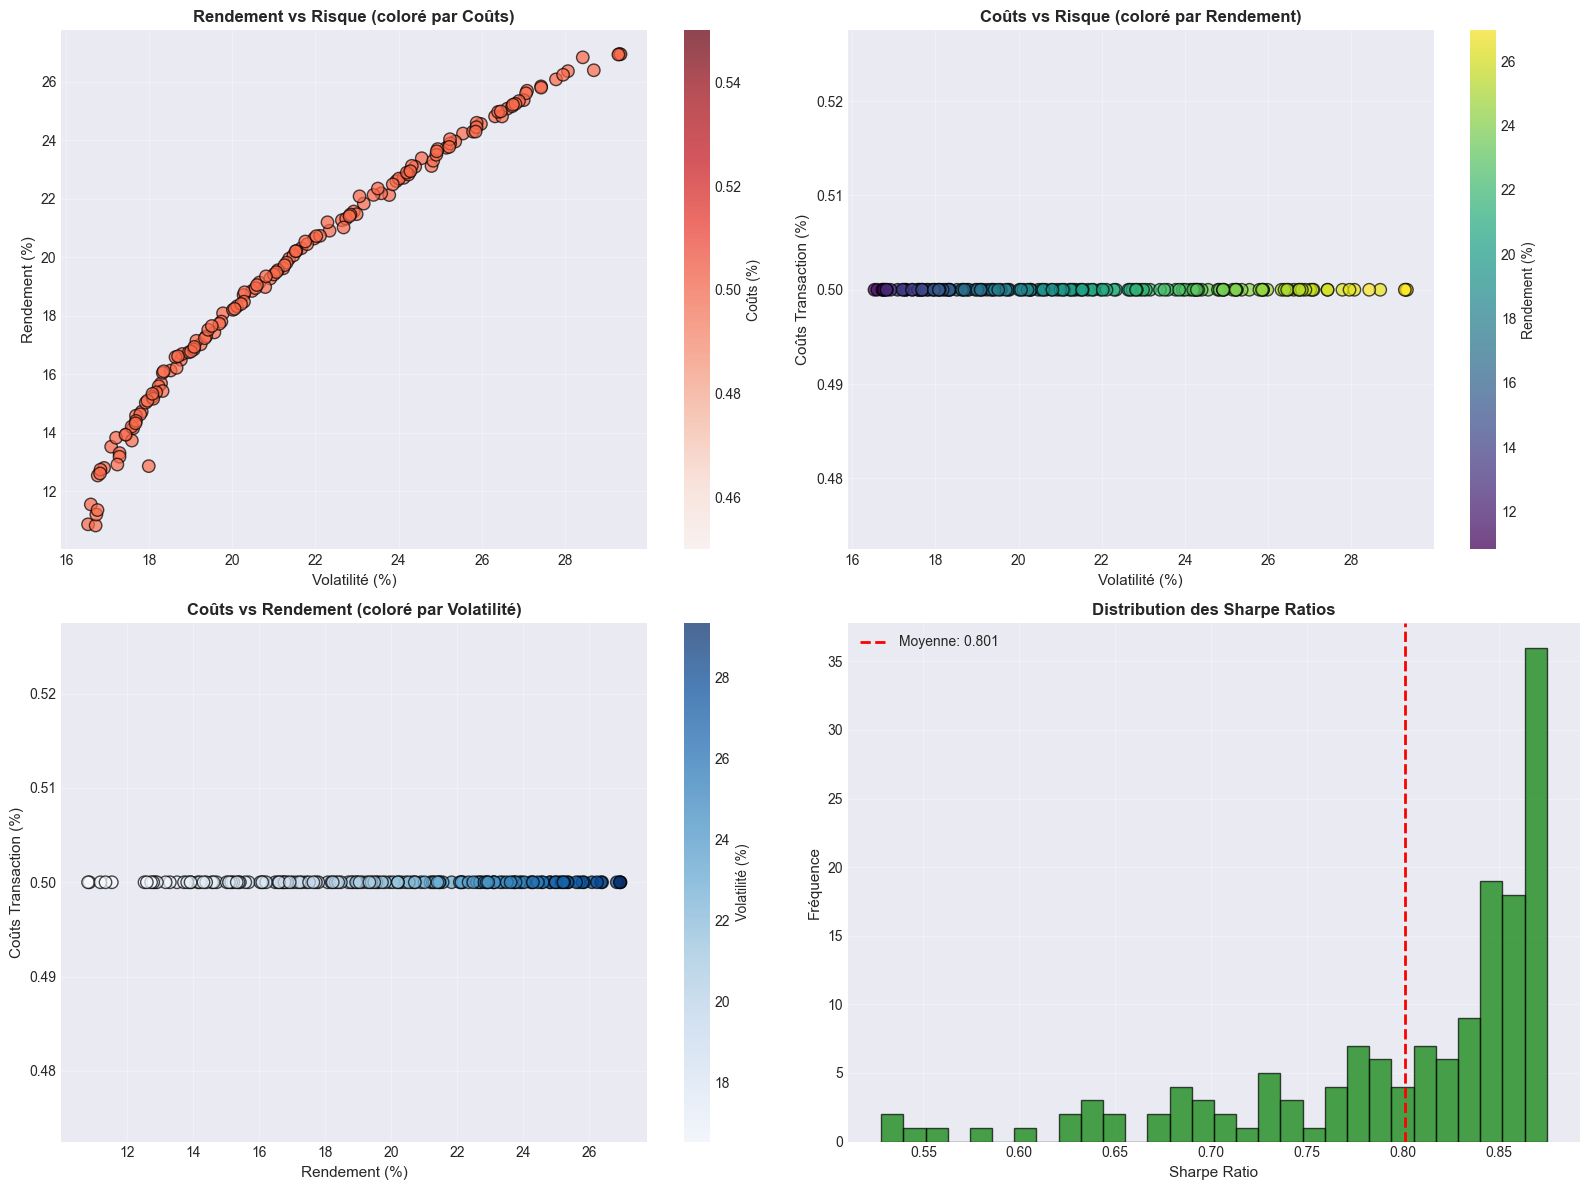

In [9]:
# Projections 2D
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Rendement vs Risque (coloré par coûts)
scatter1 = axes[0, 0].scatter(vols_tri * 100, rets_tri * 100,
                             c=costs_tri * 100, cmap='Reds', s=80, alpha=0.7, edgecolors='black')
axes[0, 0].set_xlabel('Volatilité (%)', fontsize=11)
axes[0, 0].set_ylabel('Rendement (%)', fontsize=11)
axes[0, 0].set_title('Rendement vs Risque (coloré par Coûts)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Coûts (%)', fontsize=10)

# Coûts vs Risque (coloré par rendement)
scatter2 = axes[0, 1].scatter(vols_tri * 100, costs_tri * 100,
                             c=rets_tri * 100, cmap='viridis', s=80, alpha=0.7, edgecolors='black')
axes[0, 1].set_xlabel('Volatilité (%)', fontsize=11)
axes[0, 1].set_ylabel('Coûts Transaction (%)', fontsize=11)
axes[0, 1].set_title('Coûts vs Risque (coloré par Rendement)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Rendement (%)', fontsize=10)

# Coûts vs Rendement (coloré par risque)
scatter3 = axes[1, 0].scatter(rets_tri * 100, costs_tri * 100,
                             c=vols_tri * 100, cmap='Blues', s=80, alpha=0.7, edgecolors='black')
axes[1, 0].set_xlabel('Rendement (%)', fontsize=11)
axes[1, 0].set_ylabel('Coûts Transaction (%)', fontsize=11)
axes[1, 0].set_title('Coûts vs Rendement (coloré par Volatilité)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[1, 0])
cbar3.set_label('Volatilité (%)', fontsize=10)

# Distribution des Sharpe ratios
axes[1, 1].hist(sharpe_tri, bins=30, color='green', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(sharpe_tri.mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Moyenne: {sharpe_tri.mean():.3f}')
axes[1, 1].set_xlabel('Sharpe Ratio', fontsize=11)
axes[1, 1].set_ylabel('Fréquence', fontsize=11)
axes[1, 1].set_title('Distribution des Sharpe Ratios', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sélection et Analyse d'un Portefeuille

In [10]:
# Sélection d'un portefeuille avec un rendement minimum de 15%
min_return_target = 0.15

try:
    idx_selected, w_selected = select_portfolio_from_front(
        X_tri, F_tri, min_return=min_return_target
    )
    
    ret_sel = rets_tri[idx_selected]
    vol_sel = vols_tri[idx_selected]
    cost_sel = costs_tri[idx_selected]
    sharpe_sel = sharpe_tri[idx_selected]
    card_sel = portfolio_cardinality(w_selected)
    
    print(f"✅ Portefeuille sélectionné (rendement min: {min_return_target*100}%):")
    print(f"\n📊 Métriques:")
    print(f"  Rendement: {ret_sel*100:.2f}%")
    print(f"  Volatilité: {vol_sel*100:.2f}%")
    print(f"  Coûts: {cost_sel*100:.3f}%")
    print(f"  Sharpe Ratio: {sharpe_sel:.3f}")
    print(f"  Cardinalité: {card_sel}/{K}")
    
except ValueError as e:
    print(f"❌ Erreur: {e}")
    print(f"\nRendements disponibles: [{rets_tri.min()*100:.2f}%, {rets_tri.max()*100:.2f}%]")

✅ Portefeuille sélectionné (rendement min: 15.0%):

📊 Métriques:
  Rendement: 22.13%
  Volatilité: 23.78%
  Coûts: 0.500%
  Sharpe Ratio: 0.847
  Cardinalité: 20/20


In [11]:
# Composition du portefeuille sélectionné
if 'w_selected' in locals():
    active_mask = w_selected > 1e-4
    active_tickers = [tickers[i] for i in range(n_assets) if active_mask[i]]
    active_weights = [w_selected[i] for i in range(n_assets) if active_mask[i]]
    
    sorted_idx = np.argsort(active_weights)[::-1]
    active_tickers = [active_tickers[i] for i in sorted_idx]
    active_weights = [active_weights[i] for i in sorted_idx]
    
    df_portfolio = pd.DataFrame({
        'Ticker': active_tickers,
        'Poids (%)': [w * 100 for w in active_weights],
        'Rendement (%)': [mu[tickers.index(t)] * 100 for t in active_tickers],
        'Volatilité (%)': [np.sqrt(Sigma[tickers.index(t), tickers.index(t)]) * 100 for t in active_tickers],
        'Secteur': [ticker_sectors.get(t, 'Unknown') for t in active_tickers]
    })
    
    print(f"\n🎯 Composition du portefeuille ({len(active_tickers)} actifs):")
    print(df_portfolio.to_string(index=False))


🎯 Composition du portefeuille (20 actifs):
Ticker  Poids (%)  Rendement (%)  Volatilité (%)                Secteur
  TSLA  20.267921      51.108833       65.782646 Consumer Discretionary
   CAT  13.765819      19.119244       31.957113            Industrials
    MO  11.750776       9.067160       24.193215       Consumer Staples
  CRWD  11.283848      37.384870       53.826501 Information Technology
   CHD   8.487058       8.903130       22.428499       Consumer Staples
   PSA   6.176775      10.821235       26.450999            Real Estate
  MDLZ   4.567120       4.098536       21.660321       Consumer Staples
  NFLX   4.254761      19.212813       46.018214 Communication Services
   HSY   4.146308       5.231143       24.095700       Consumer Staples
    PG   3.406861       8.305717       20.537101       Consumer Staples
  AMGN   3.385280       4.536690       25.607328            Health Care
  EQIX   3.298281      11.127096       30.157814            Real Estate
   HON   1.993930   

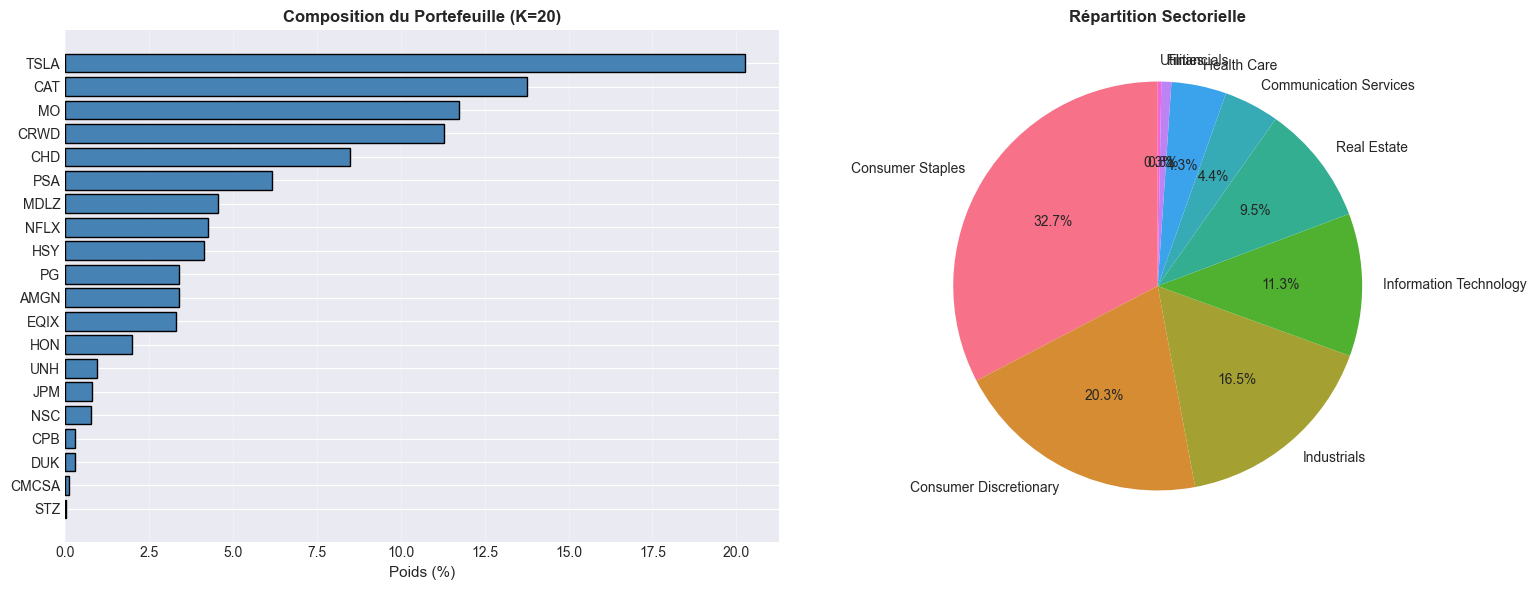

In [12]:
# Visualisation de la composition
if 'df_portfolio' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Barplot des poids
    axes[0].barh(df_portfolio['Ticker'], df_portfolio['Poids (%)'],
                color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Poids (%)', fontsize=11)
    axes[0].set_title(f'Composition du Portefeuille (K={card_sel})', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()
    
    # Répartition sectorielle
    sector_weights = df_portfolio.groupby('Secteur')['Poids (%)'].sum().sort_values(ascending=False)
    axes[1].pie(sector_weights, labels=sector_weights.index, autopct='%1.1f%%',
               startangle=90, colors=sns.color_palette('husl', len(sector_weights)))
    axes[1].set_title('Répartition Sectorielle', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 7. Analyse de la Diversité du Front de Pareto

In [13]:
# Analyse de la diversité
print("📊 Analyse de la diversité des solutions:\n")

# Cardinalité
print(f"Cardinalité:")
print(f"  Moyenne: {np.mean(cards_tri):.1f}")
print(f"  Écart-type: {np.std(cards_tri):.1f}")
print(f"  Min-Max: [{min(cards_tri)}, {max(cards_tri)}]")

# Rendements
print(f"\nRendements:")
print(f"  Moyenne: {rets_tri.mean()*100:.2f}%")
print(f"  Écart-type: {rets_tri.std()*100:.2f}%")
print(f"  Étendue: {(rets_tri.max() - rets_tri.min())*100:.2f}%")

# Volatilités
print(f"\nVolatilités:")
print(f"  Moyenne: {vols_tri.mean()*100:.2f}%")
print(f"  Écart-type: {vols_tri.std()*100:.2f}%")
print(f"  Étendue: {(vols_tri.max() - vols_tri.min())*100:.2f}%")

# Coûts
print(f"\nCoûts de transaction:")
print(f"  Moyenne: {costs_tri.mean()*100:.3f}%")
print(f"  Écart-type: {costs_tri.std()*100:.3f}%")
print(f"  Étendue: {(costs_tri.max() - costs_tri.min())*100:.3f}%")

# Sharpe ratios
print(f"\nSharpe Ratios:")
print(f"  Moyenne: {sharpe_tri.mean():.3f}")
print(f"  Écart-type: {sharpe_tri.std():.3f}")
print(f"  Min-Max: [{sharpe_tri.min():.3f}, {sharpe_tri.max():.3f}]")

📊 Analyse de la diversité des solutions:

Cardinalité:
  Moyenne: 20.0
  Écart-type: 0.0
  Min-Max: [20, 20]

Rendements:
  Moyenne: 19.67%
  Écart-type: 4.28%
  Étendue: 16.13%

Volatilités:
  Moyenne: 21.77%
  Écart-type: 3.52%
  Étendue: 12.80%

Coûts de transaction:
  Moyenne: 0.500%
  Écart-type: 0.000%
  Étendue: 0.000%

Sharpe Ratios:
  Moyenne: 0.801
  Écart-type: 0.082
  Min-Max: [0.528, 0.875]


C:\Users\redlam\AppData\Local\Temp\ipykernel_47744\2633574340.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_objectives, labels=['Rendement (%)', 'Volatilité (%)', 'Coûts (%)'],


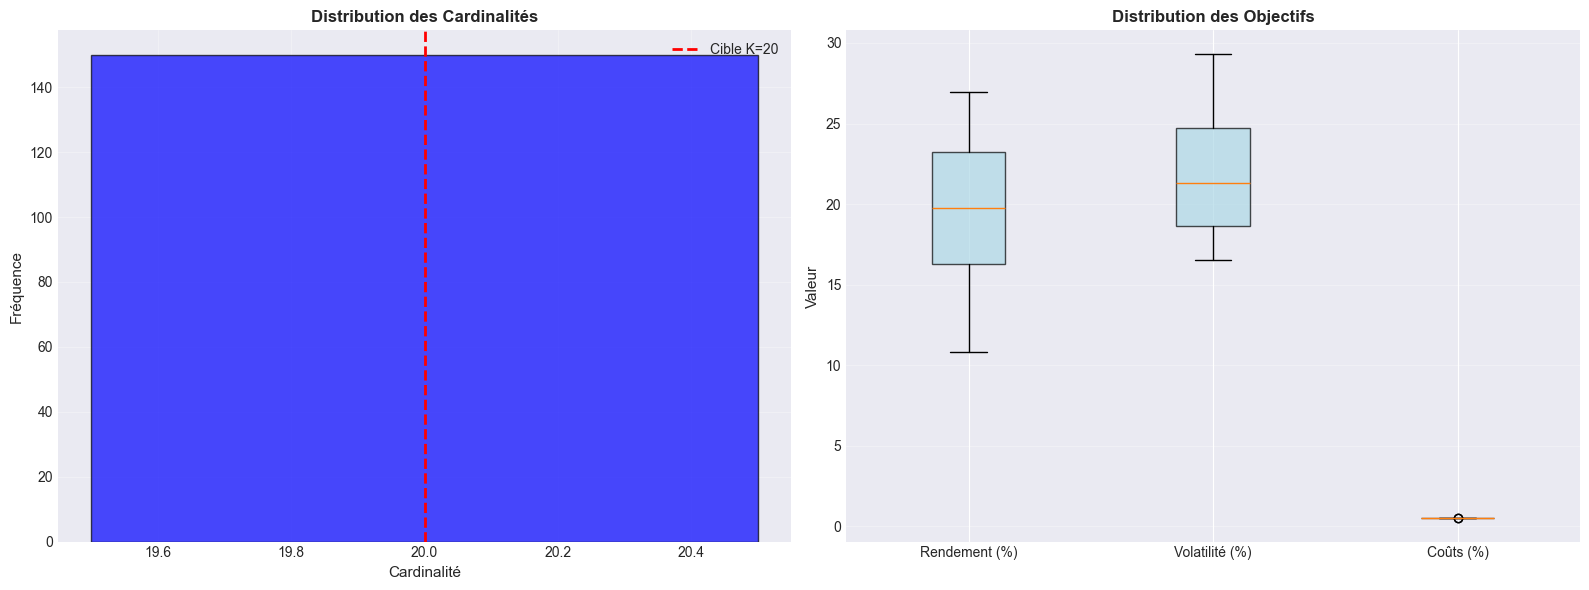

In [14]:
# Distribution des cardinalités
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(cards_tri, bins=range(min(cards_tri), max(cards_tri)+2), 
            color='blue', edgecolor='black', alpha=0.7, align='left')
axes[0].axvline(K, color='red', linestyle='--', linewidth=2, label=f'Cible K={K}')
axes[0].set_xlabel('Cardinalité', fontsize=11)
axes[0].set_ylabel('Fréquence', fontsize=11)
axes[0].set_title('Distribution des Cardinalités', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Boxplots des objectifs
data_objectives = [rets_tri * 100, vols_tri * 100, costs_tri * 100]
axes[1].boxplot(data_objectives, labels=['Rendement (%)', 'Volatilité (%)', 'Coûts (%)'],
               patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Valeur', fontsize=11)
axes[1].set_title('Distribution des Objectifs', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Comparaison Finale: Markowitz vs NSGA-II

In [15]:
# Tableau comparatif
comparison_data = []

# Markowitz Tangent
comparison_data.append({
    'Méthode': 'Markowitz Tangent',
    'Rendement (%)': ret_tangent * 100,
    'Volatilité (%)': vol_tangent * 100,
    'Sharpe': sharpe_ratio(w_tangent, mu, Sigma, rf),
    'Cardinalité': portfolio_cardinality(w_tangent),
    'Coûts (%)': transaction_costs(w_tangent, w_current, c_prop) * 100
})

# NSGA-II bi-objectif (meilleur Sharpe)
idx_best_sharpe_bi = np.argmax((rets_nsga_bi - rf) / vols_nsga_bi)
comparison_data.append({
    'Méthode': 'NSGA-II bi-obj (meilleur Sharpe)',
    'Rendement (%)': rets_nsga_bi[idx_best_sharpe_bi] * 100,
    'Volatilité (%)': vols_nsga_bi[idx_best_sharpe_bi] * 100,
    'Sharpe': (rets_nsga_bi[idx_best_sharpe_bi] - rf) / vols_nsga_bi[idx_best_sharpe_bi],
    'Cardinalité': portfolio_cardinality(X_nsga_bi[idx_best_sharpe_bi]),
    'Coûts (%)': transaction_costs(X_nsga_bi[idx_best_sharpe_bi], w_current, c_prop) * 100
})

# NSGA-II bi-objectif avec K (meilleur Sharpe)
idx_best_sharpe_K = np.argmax((rets_nsga_bi_K - rf) / vols_nsga_bi_K)
comparison_data.append({
    'Méthode': f'NSGA-II bi-obj K={K} (meilleur Sharpe)',
    'Rendement (%)': rets_nsga_bi_K[idx_best_sharpe_K] * 100,
    'Volatilité (%)': vols_nsga_bi_K[idx_best_sharpe_K] * 100,
    'Sharpe': (rets_nsga_bi_K[idx_best_sharpe_K] - rf) / vols_nsga_bi_K[idx_best_sharpe_K],
    'Cardinalité': portfolio_cardinality(X_nsga_bi_K[idx_best_sharpe_K]),
    'Coûts (%)': transaction_costs(X_nsga_bi_K[idx_best_sharpe_K], w_current, c_prop) * 100
})

# NSGA-II tri-objectif (meilleur Sharpe)
idx_best_sharpe_tri = np.argmax(sharpe_tri)
comparison_data.append({
    'Méthode': f'NSGA-II tri-obj K={K} (meilleur Sharpe)',
    'Rendement (%)': rets_tri[idx_best_sharpe_tri] * 100,
    'Volatilité (%)': vols_tri[idx_best_sharpe_tri] * 100,
    'Sharpe': sharpe_tri[idx_best_sharpe_tri],
    'Cardinalité': portfolio_cardinality(X_tri[idx_best_sharpe_tri]),
    'Coûts (%)': costs_tri[idx_best_sharpe_tri] * 100
})

df_comparison = pd.DataFrame(comparison_data)
print("📊 TABLEAU COMPARATIF DES MÉTHODES:\n")
print(df_comparison.to_string(index=False))

📊 TABLEAU COMPARATIF DES MÉTHODES:

                               Méthode  Rendement (%)  Volatilité (%)   Sharpe  Cardinalité  Coûts (%)
                     Markowitz Tangent      16.110935       20.650180 0.683332           95        0.5
      NSGA-II bi-obj (meilleur Sharpe)      17.799738       23.657074 0.667865           20        0.5
 NSGA-II bi-obj K=20 (meilleur Sharpe)      31.436378       31.269284 0.941383           20        0.5
NSGA-II tri-obj K=20 (meilleur Sharpe)      25.697145       27.089369 0.874777           20        0.5


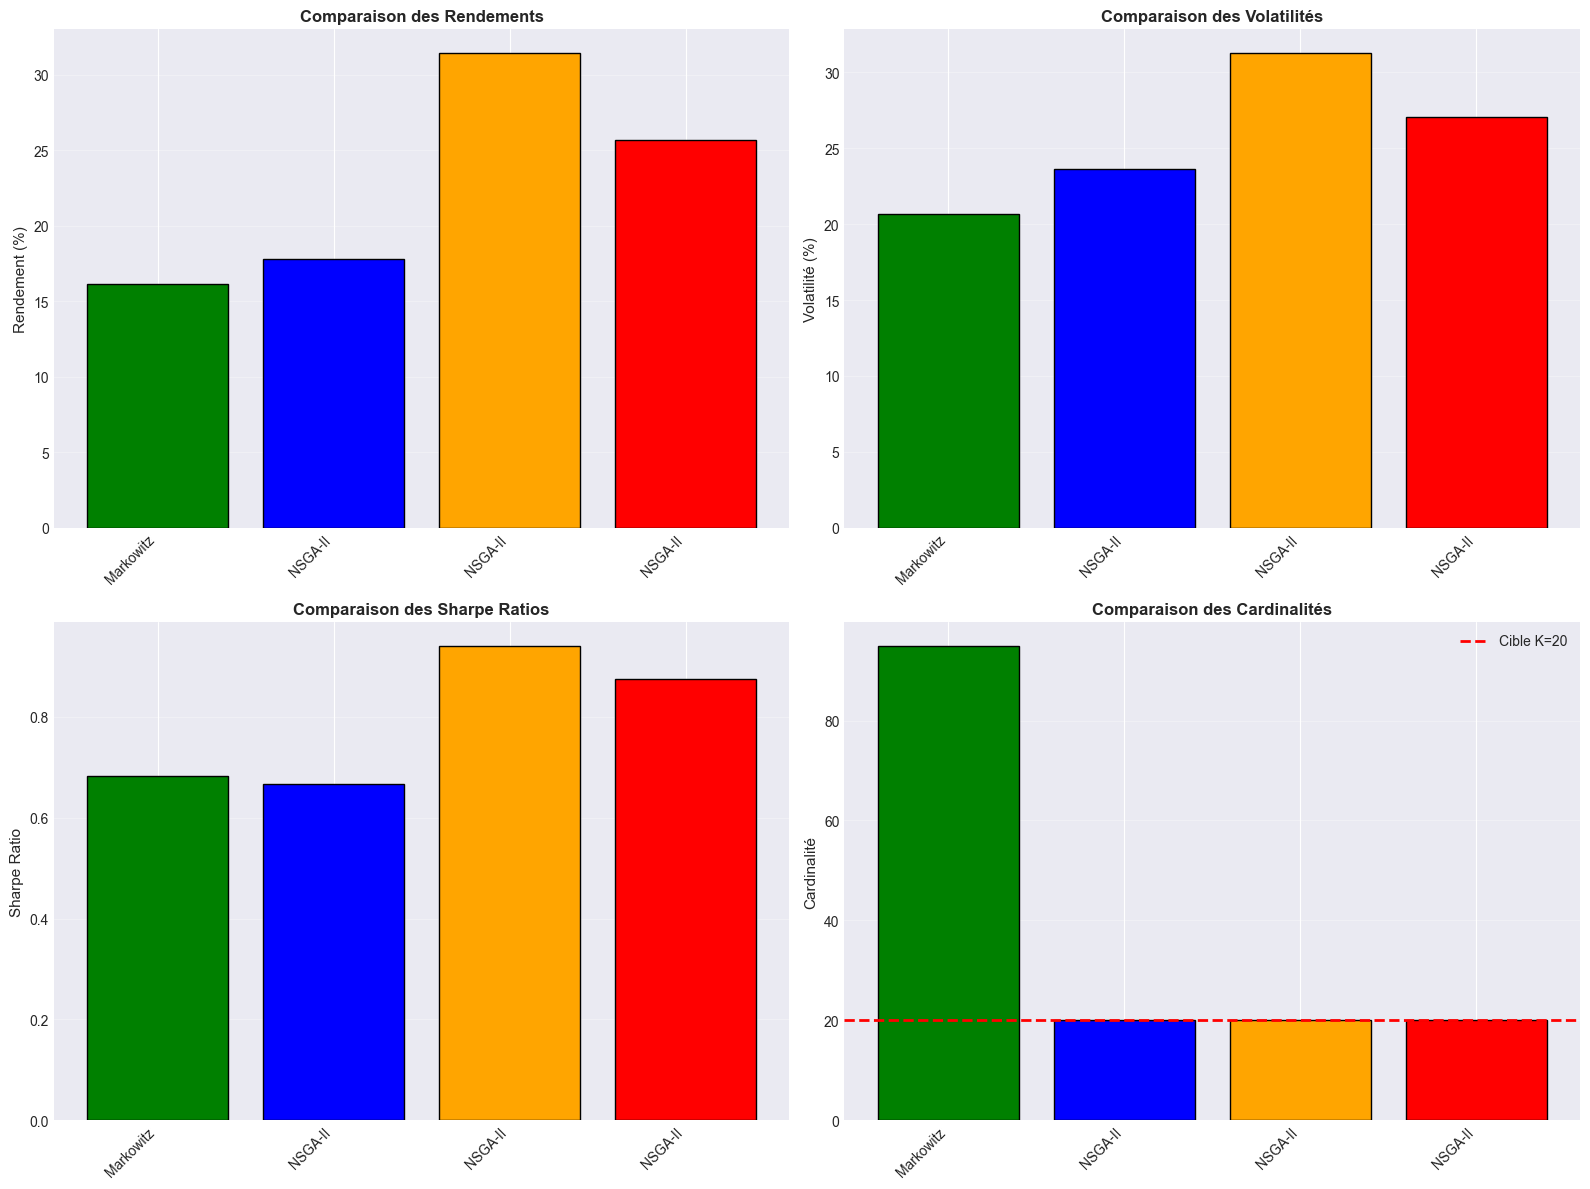

In [16]:
# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = df_comparison['Méthode'].tolist()
colors_comp = ['green', 'blue', 'orange', 'red']

# Rendements
axes[0, 0].bar(range(len(methods)), df_comparison['Rendement (%)'], color=colors_comp, edgecolor='black')
axes[0, 0].set_xticks(range(len(methods)))
axes[0, 0].set_xticklabels([m.split()[0] for m in methods], rotation=45, ha='right')
axes[0, 0].set_ylabel('Rendement (%)', fontsize=11)
axes[0, 0].set_title('Comparaison des Rendements', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Volatilités
axes[0, 1].bar(range(len(methods)), df_comparison['Volatilité (%)'], color=colors_comp, edgecolor='black')
axes[0, 1].set_xticks(range(len(methods)))
axes[0, 1].set_xticklabels([m.split()[0] for m in methods], rotation=45, ha='right')
axes[0, 1].set_ylabel('Volatilité (%)', fontsize=11)
axes[0, 1].set_title('Comparaison des Volatilités', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Sharpe Ratios
axes[1, 0].bar(range(len(methods)), df_comparison['Sharpe'], color=colors_comp, edgecolor='black')
axes[1, 0].set_xticks(range(len(methods)))
axes[1, 0].set_xticklabels([m.split()[0] for m in methods], rotation=45, ha='right')
axes[1, 0].set_ylabel('Sharpe Ratio', fontsize=11)
axes[1, 0].set_title('Comparaison des Sharpe Ratios', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Cardinalités
axes[1, 1].bar(range(len(methods)), df_comparison['Cardinalité'], color=colors_comp, edgecolor='black')
axes[1, 1].axhline(K, color='red', linestyle='--', linewidth=2, label=f'Cible K={K}')
axes[1, 1].set_xticks(range(len(methods)))
axes[1, 1].set_xticklabels([m.split()[0] for m in methods], rotation=45, ha='right')
axes[1, 1].set_ylabel('Cardinalité', fontsize=11)
axes[1, 1].set_title('Comparaison des Cardinalités', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Sauvegarde des Résultats

In [17]:
# Sauvegarde
output_dir = Path('../data/processed')

# Front de Pareto tri-objectif
np.savez(output_dir / 'pareto_front_nsga2_tri.npz',
         portfolios=X_tri,
         returns=rets_tri,
         risks=risks_tri,
         costs=costs_tri,
         volatilities=vols_tri,
         cardinalities=cards_tri)

# Front de Pareto bi-objectif avec K
np.savez(output_dir / 'pareto_front_nsga2_bi_K.npz',
         portfolios=X_nsga_bi_K,
         returns=rets_nsga_bi_K,
         risks=risks_nsga_bi_K,
         volatilities=vols_nsga_bi_K)

# Tableau comparatif
df_comparison.to_csv(output_dir / 'methods_comparison.csv', index=False)

print("✅ Résultats NSGA-II sauvegardés dans:", output_dir)
print("  - pareto_front_nsga2_tri.npz")
print("  - pareto_front_nsga2_bi_K.npz")
print("  - methods_comparison.csv")

✅ Résultats NSGA-II sauvegardés dans: ..\data\processed
  - pareto_front_nsga2_tri.npz
  - pareto_front_nsga2_bi_K.npz
  - methods_comparison.csv


## 🎯 Conclusions

**Observations principales:**

1. **Dominance de Pareto:** Le front 3D offre un ensemble riche de solutions non-dominées
2. **Contrainte de cardinalité:** NSGA-II respecte efficacement la contrainte K=20
3. **Trade-offs multiples:** 
   - Rendement élevé ⟷ Risque élevé
   - Faibles coûts ⟷ Portefeuille proche de l'actuel
   - Diversification ⟷ Coûts de transaction

4. **Comparaison avec Markowitz:**
   - Markowitz: Excellents Sharpe ratios mais cardinalité élevée
   - NSGA-II avec K: Sharpe légèrement inférieurs mais cardinalité contrôlée
   - Tri-objectif: Intègre explicitement les coûts de transaction

5. **Diversité des solutions:** Le front de Pareto offre de nombreuses options pour différents profils

**Avantages de NSGA-II:**
- Gère naturellement les contraintes non-convexes (cardinalité)
- Produit un ensemble de solutions (pas une seule)
- Flexible pour ajouter d'autres objectifs ou contraintes
- Robuste aux non-convexités du problème

**Limites:**
- Temps de calcul plus élevé que Markowitz
- Pas de garantie d'optimalité globale
- Nécessite un réglage des paramètres (pop_size, n_gen)

**➡️ Prochaine étape:** Application interactive Streamlit pour exploration